## 003 : 3-Hidden Layer CNN with Data Augmentation

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
from keras.models import load_model
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

/home/che/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../315f7638'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [3]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [4]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [5]:
y_train_oh[:3] # binary problem

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

In [6]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [7]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_3layer_v2_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       55424     
__________

None

In [8]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1] [1 1 2 2 1 2 2 2 2 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 2 2 2 1 1 1 1 2 1 2 1 2 1
 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 2 2 2 1 2 2 1 1 1 2 1 1 2
 1 1 1 1 2 1 1 2 1 1 1 2 2 1 1 1 1 2 2 1 2 2 1 1 2 1] [2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 1
 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1 2]


In [9]:
epochs = 10
batch_size = 32

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(1)])

Train on 3093 samples, validate on 256 samples
Epoch 1/10
3093/3093 [==============================] - 11s 4ms/step - loss: 0.3796 - acc: 0.8657 - val_loss: 1.1152 - val_acc: 0.5625
Epoch 2/10
3093/3093 [==============================] - 7s 2ms/step - loss: 0.2955 - acc: 0.8765 - val_loss: 1.4117 - val_acc: 0.4766
Epoch 3/10
3093/3093 [==============================] - 7s 2ms/step - loss: 0.2877 - acc: 0.8859 - val_loss: 1.0607 - val_acc: 0.6309
Epoch 4/10
3093/3093 [==============================] - 7s 2ms/step - loss: 0.2515 - acc: 0.9014 - val_loss: 0.8883 - val_acc: 0.6113
Epoch 5/10
3093/3093 [==============================] - 7s 2ms/step - loss: 0.2119 - acc: 0.9179 - val_loss: 1.8824 - val_acc: 0.5879

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
3093/3093 [==============================] - 7s 2ms/step - loss: 0.2093 - acc: 0.9187 - val_loss: 1.0084 - val_acc: 0.5645

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500

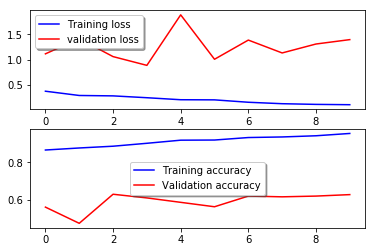

Precision (specificity): 72.845%
Recall (sensitivity): 79.134%
Accuracy: 82.338%
F1: 74.958%


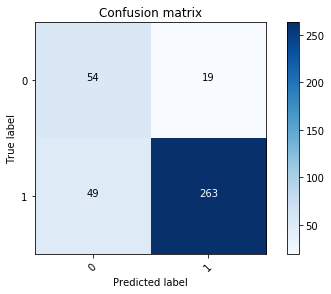

In [10]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [14]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-8528141b [0.85357404 0.1440353 ] 0
hgv-2cdb69f6 [0.10868534 0.8851979 ] 0
odi-0294ae4c [6.5628166e-07 9.9999940e-01] 1
mdi-f3f9ede5 [9.615361e-11 1.000000e+00] 1
hgv-99fc12a1 [0.5070006  0.48262247] 0
hgv-6d2317b0 [0.3746417 0.6187639] 1


In [15]:
model.save('001_model_r1.h5')

In [19]:
model = cnn_models.model_3layer_v2_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_15 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       55424     
__________

None

In [20]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

epochs2 = 5
batch_size2 = 32

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history2 = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size2),
                              epochs = epochs2, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer(), cnn_models.early_stopping()])

Epoch 1/5
3093/3093 [==============================] - 226s 73ms/step - loss: 0.2311 - acc: 0.8989 - val_loss: 0.8144 - val_acc: 0.6387
Epoch 2/5
3093/3093 [==============================] - 225s 73ms/step - loss: 0.1550 - acc: 0.9360 - val_loss: 2.5419 - val_acc: 0.6484
Epoch 3/5
3093/3093 [==============================] - 225s 73ms/step - loss: 0.1374 - acc: 0.9446 - val_loss: 1.2868 - val_acc: 0.6836
Epoch 00003: early stopping


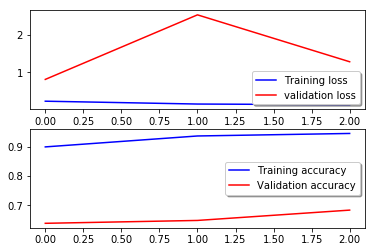

Precision (specificity): 70.552%
Recall (sensitivity): 75.549%
Accuracy: 80.779%
F1: 72.301%


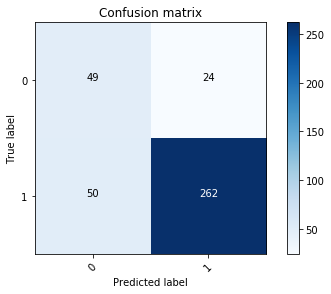

In [21]:
render.plot_training_and_validation_curves(history2)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [22]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-8528141b [0.7253022  0.27336782] 0
hgv-2cdb69f6 [0.2660295 0.7351962] 0
odi-0294ae4c [0.0109933 0.9887484] 1
mdi-f3f9ede5 [6.319455e-05 9.999454e-01] 1
hgv-99fc12a1 [0.33800188 0.6633193 ] 0
hgv-6d2317b0 [0.38115597 0.6168164 ] 1


In [23]:
model.save('model_001_r2.h5')